In [1]:

import csv
from six import StringIO
import tempfile
import numpy as np

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tk.models import similarity_transformer
from tk.data_generators import function_docstring

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


# Multi-problem, single network experiment

Here we'll experiment with a problem that mixes the two in-painting example types, using the same network to solve both problems. This is towards training a single encoder that can later be used for both doc strings and code, circumventing the need to specifically train code and doc strings to be embedded into the same space.


## Problem definition

In [2]:

def _random_mask_sequence(sequence):
  """'quick brown fox' -> 'quick ##### fox'"""
  arr = sequence.split()
  ind = np.random.randint(len(arr))
  arr[ind] = ''.join(["#" for _ in range(0, len(arr[ind]))])
  return ' '.join(arr)


In [3]:

# TODO: Could yield with certain probabilities to control abundance
# TODO: In-paintable region could be of variable size and distribution
# TODO: Do this using preprocess step instead of generating completely new set of examples?

@registry.register_problem
class GithubMultiProblemBase(function_docstring.GithubFunctionDocstring):
  """Code in-painting given randomly ablated regions."""

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:

            yield {
                "inputs": _random_mask_sequence(function_tokens),
                "targets": function_tokens,
                "embed_code": [0]
            }

            yield {
                "inputs": _random_mask_sequence(docstring_tokens),
                "targets": docstring_tokens,
                "embed_code": [0]
            }


In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
multi_problem = GithubMultiProblemBase()
multi_problem.generate_data(data_dir, tmp_dir)


## Training

In [9]:

from tk.experiment import configure_experiment, T2TExperiment

args = configure_experiment("cs-multi1",
                             problem="github_multi_problem_base",
                             hparams_set="transformer_tiny",
                             model="transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'transformer_tiny',
 'log_device_placement': False,
 'model': 'transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/output',
 'problem': 'github_multi_problem_base',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-14 19:08:24,352] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-14 19:08:25,466] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-14 19:08:25,891] Finished loading event data for comparison.


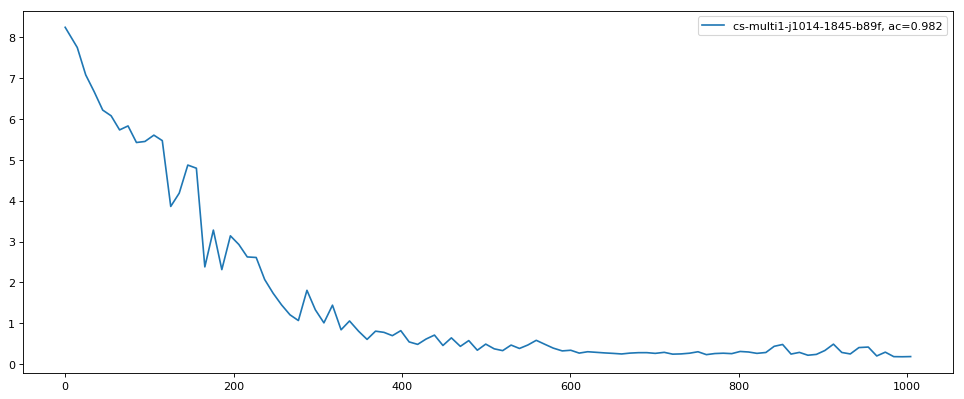

In [2]:

#from tk.allen_demo import event_data_for_comparison, show_experiment_loss
#%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-multi1*")
show_experiment_loss(experiment_data)


## Alternative problem

Hmmm so there's no guarantee pairs will be embedded in a similar way here. But it might just happen. But if not, can train at the same time to produce corresponding embeddings...

This supposes our examples are of the form: 

```python
{
    "inputs": "some input, e.g. masked code",
    "targets": "some corresponding target, e.g. unmasked code",
    "docstring": "a docstring to embed",
    "code": "code to embed"
}
```

where the inputs/targets pair is only masked docstring/docstring or masked code/code for the sake of simplicity of implementation. if we only do one at a time instead of both then we can just return the tensor produced by super(Transformer, self).body() instead of having to manually call self.loss.


In [3]:

from tensor2tensor.layers import common_layers

def random_mask(tensor):
  mask = tf.random_uniform(common_layers.shape_list(tensor),
                           0, 10, dtype=tf.float32)
  mask = tf.cast(tf.greater(mask, 1), tf.int64)
  return tf.multiply(tensor, mask)

@registry.register_problem
class GithubConstrainedEmbedding(function_docstring.GithubFunctionDocstring):

  def dataset_filename(self):
    return "github_function_docstring"  # Reuse base problem data

  def preprocess_example(self, example, mode, hparams):

    example["docstring"] = example["inputs"]
    example["code"] = example["targets"]
    if np.random.randint(2) == 0:
      # docstring un-masking
      example["targets"] = example["inputs"]
      example["inputs"] = random_mask(example["inputs"])
    else:
      # code un-masking
      example["inputs"] = random_mask(example["targets"])

    return example


It would be a lot cleaner to just have a variety of example types (non-overlapping) and have body be conditional on the example type code.

In [4]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
mp_constrained_embedding = GithubConstrainedEmbedding()
mp_constrained_embedding.generate_data(data_dir, tmp_dir)


INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


[2018-10-16 20:31:19,770] Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-10-16 20:31:19,842] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-10-16 20:31:19,850] Skipping shuffle because output files exist


In [5]:

train_dataset = mp_constrained_embedding.dataset(Modes.TRAIN, data_dir)
ds = tfe.Iterator(train_dataset)
print ds.next()


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


[2018-10-16 20:31:19,933] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-16 20:31:19,951] partition: 0 num_data_files: 100


{'code': <tf.Tensor: id=70, shape=(445,), dtype=int64, numpy=
array([   7,  802,    2,  205,    3,   23,   21, 4128,   70,  258,  187,
       4226,  187, 4226, 4578, 4016,   58, 1049, 5044,    4,   67, 1742,
       1049, 2311, 4128,   70, 4128,   70, 5044,    4,   10,  444, 4128,
         70,    3,  205,    2,  146,   10,    3,  205,    2,  146,   12,
        653, 4226, 5399,  582, 7013, 3401,    4, 3901, 1124,   28, 6551,
       5044,    4, 2644,   10,   12,  727,   10,  444,  446,   10,   12,
        432,   10,  444, 3536, 4334,   10, 3860, 4187, 4334,   10,  424,
          2, 5779,    5,   12, 5044,    4,  273,    2, 5779,    5,   12,
         10, 2572, 3197,  318, 4226, 2019,  782, 3197,   53,    2, 1535,
        605,  743, 2464, 1017,  407,   12,   10,   13,  346,   11,  147,
         10, 5044,    4,   28,   28,  506, 1049, 5190,    4,  653,  346,
       4213, 7056,    5,  789, 3578,    4,    3,  205,    2,  227, 1037,
         34, 1049, 5190,    4,  653,  346,   12,    6,  346,  

### Model

In [9]:

from tensor2tensor.models.transformer import Transformer
from tk.models.similarity_transformer import similarity_cost

@registry.register_model
class ConstrainedEmbeddingTransformer(Transformer):

  def body(self, features):
    hparams = self._hparams
    target_space = problem.SpaceID.EN_TOK

    if self._hparams.mode == tf.estimator.ModeKeys.PREDICT:
      encoded, _ = self.encode(features["predictme"], target_space, hparams,
                               features=features)
      return tf.reduce_mean(encoded, axis=1), {"training": 0.0}
  
    features_alt = {"inputs":features["docstring"], "targets":features["code"]}
    features_alt = self.bottom(features_alt)

    string_embedding, _ = self.encode(features_alt["inputs"], target_space, hparams,
                                      features=features_alt)
    string_embedding = tf.reduce_mean(string_embedding, axis=1)
    code_embedding, _ = self.encode(features_alt["targets"], target_space, hparams,
                                    features=features_alt)
    code_embedding = tf.reduce_mean(code_embedding, axis=1)
    
    sc = similarity_cost(string_embedding, code_embedding, self.hparams.loss_variant)

    ret = super(ConstrainedEmbeddingTransformer, self).body(features)

    if isinstance(ret, tf.Tensor) or isinstance(ret, tf.EagerTensor):
      return ret, {"similarity": sc}
    elif isinstance(ret, tuple):
      if not isinstance(ret[1], dict):
        raise ValueError("Unexpected second type in superclass body return.")
      ret[1]["similarity"] = sc
      return ret


#### Model testing

Let's verify our model trains with tfe as implemented.

In [10]:

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.TRAIN, p_hparams
)

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.TRAIN, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

optimizer = tf.train.AdamOptimizer()


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-16 20:31:29,234] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


[2018-10-16 20:31:29,238] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-16 20:31:29,253] partition: 0 num_data_files: 100


In [11]:

@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

NUM_STEPS = 10

for count, example in enumerate(tfe.Iterator(train_dataset)):
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 1 == 0:
   print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
   break


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8185_128.bottom


[2018-10-16 20:31:30,063] Transforming feature 'inputs' with symbol_modality_8185_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8185_128.targets_bottom


[2018-10-16 20:31:30,279] Transforming 'targets' with symbol_modality_8185_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-16 20:31:30,286] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_8185_128.top


[2018-10-16 20:31:30,638] Transforming body output with symbol_modality_8185_128.top


Step: 0, Loss: 8.026
Step: 1, Loss: 8.169
Step: 2, Loss: 6.905
Step: 3, Loss: 6.841
Step: 4, Loss: 8.014
Step: 5, Loss: 7.501
Step: 6, Loss: 7.102
Step: 7, Loss: 6.911
Step: 8, Loss: 7.617
Step: 9, Loss: 7.953
Step: 10, Loss: 6.856


## Training

In [1]:
from tk.experiment import configure_experiment, T2TExperiment

from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline


In [15]:

args = configure_experiment("cs-ce3",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-ce3/cs-ce3-j1016-2037-f912/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-ce3/cs-ce3-j1016-2037-f912/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 20:58:19,545] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 20:58:20,649] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 20:58:21,369] Finished loading event data for comparison.


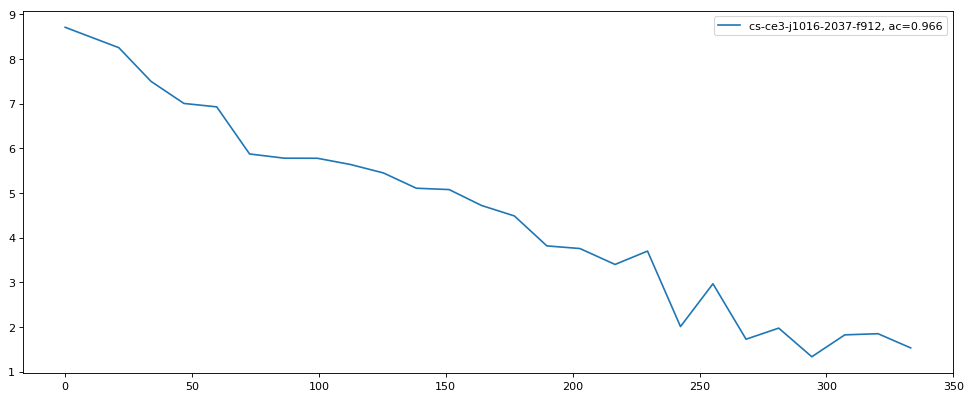

In [6]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-ce3*")
show_experiment_loss(experiment_data)

## Multi-gpu training

In [16]:

args = configure_experiment("cs-gpu4",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=4,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4/cs-gpu4-j1016-2046-f235/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4/cs-gpu4-j1016-2046-f235/tk',
 'train_steps': 10000,
 'worker_gpu': 4,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 21:06:49,480] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 21:06:50,593] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 21:06:51,819] Finished loading event data for comparison.


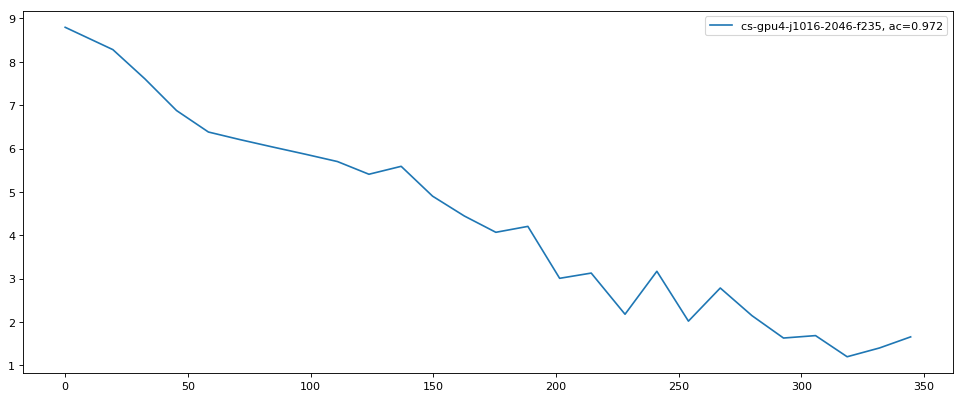

In [3]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4*")
show_experiment_loss(experiment_data)

In [ ]:
Seeing containers restarting around the same step number ...

## Distributed training

In [5]:

args = configure_experiment("cs-dist",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000,
                             num_ps=4,
                             schedule="train_and_evaluate")

job = T2TExperiment(**args)
job.run()


[2018-10-16 21:12:43,870] /mnt/nfs-east1-d/work/tk
[2018-10-16 21:12:43,913] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist/cs-dist-j1016-2112-6e89/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train_and_evaluate',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-16 21:12:52,391] smoke: True


In [ ]:
fails with error 

INFO:tensorflow:worker_gpu=0
INFO:tensorflow:sync=True
Traceback (most recent call last):
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk/experiment.py", line 400, in <module>
    tf.app.run()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk/experiment.py", line 395, in main
    trainer_main(None)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/bin/t2t_trainer.py", line 354, in main
    exp = exp_fn(create_run_config(hparams), hparams)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/bin/t2t_trainer.py", line 227, in create_run_config
    intra_op_parallelism_threads=FLAGS.intra_op_parallelism_threads)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/utils/trainer_lib.py", line 171, in create_run_config
    no_data_parallelism=no_data_parallelism)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/utils/devices.py", line 137, in data_parallelism
    assert not sync
AssertionError

In [6]:

args = configure_experiment("cs-dist-tr",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000,
                             num_ps=4,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


[2018-10-16 21:15:24,949] /mnt/nfs-east1-d/work/tk
[2018-10-16 21:15:24,959] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr/cs-dist-tr-j1016-2115-ca9f/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr/cs-dist-tr-j1016-2115-ca9f/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-16 21:15:36,075] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 21:26:32,640] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 21:26:33,825] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 21:26:37,608] Finished loading event data for comparison.


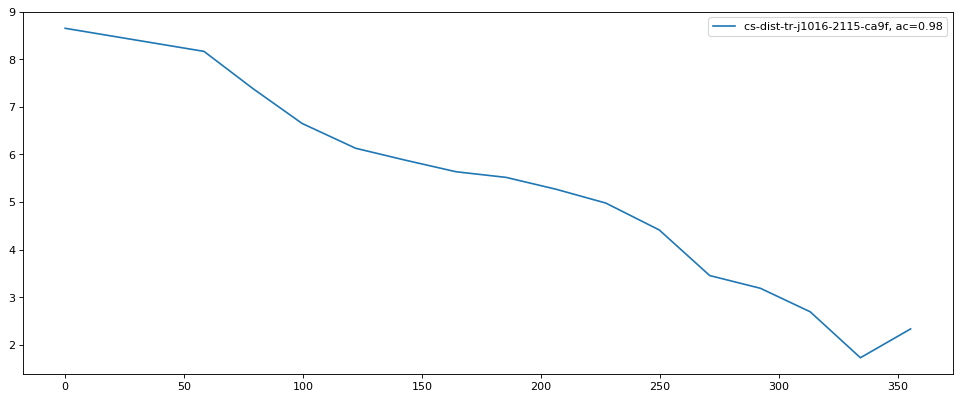

In [7]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr*")
show_experiment_loss(experiment_data)

My guess is that it is indeed using all of the workers because the loss curve looks much smoother than that of the single gpu condition. I am not clear on why the 4x gpu condition isn't smoother as well though (perhaps it's misconfigured).